 ***VGG16  обучение только классификатора.***

In [0]:
import zipfile
import os
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import precision_score, recall_score, f1_score

plt.ion()   # interactive mode

In [0]:
z = zipfile.ZipFile('flowers (2).zip')
z.extractall()

In [0]:
p = zipfile.ZipFile('test.zip')
p.extractall()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),#обрезать изображение случайным образом
        transforms.ToTensor(),#преобразовывает ndarrays экземпляра в Tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = './flowers/flowers'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
# специальный класс для загрузки данных в виде батчей
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                             shuffle=True, num_workers=4), 
               'valid': torch.utils.data.DataLoader(image_datasets[ 'valid'], batch_size=4,
                                             shuffle=True, num_workers=4),
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

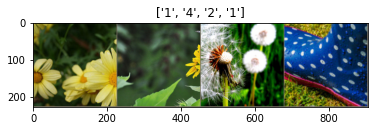

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, doc_train="doc_train.txt", doc_valid="doc_valid.txt" ):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    best_precision = 0.0
    best_recall = 0.0
    loss_in_epoch = {'train': [], 'valid':[]}
    correctss_in_epoch = {'train': [], 'valid':[]}
    f1_in_epoch = {'train': [], 'valid':[]}
    precision_in_epoch = {'train': [], 'valid':[]}
    recall_in_epoch = {'train': [], 'valid':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            running_f1 =[]
            running_precision = []
            running_recall = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_f1.append( f1_score(labels.data.numpy(),preds.numpy(),average='micro'))
                running_precision.append(precision_score(labels.data.numpy(), preds.numpy(),average='micro'))
                running_recall.append(recall_score(labels.data.numpy(), preds.numpy(),average='micro'))
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = np.mean(running_f1)
            epoch_precision = np.mean(running_precision)
            epoch_recall = np.mean(running_recall)
            epoch__corrects=running_corrects / dataset_sizes[phase]


            print('{} F1: {:.4f} Precision: {:.4f} Recall: {:.4f}'.format(
                phase, epoch_f1, epoch_precision, epoch_recall))
            loss_in_epoch[phase].append(epoch_loss)
            correctss_in_epoch[phase].append(epoch__corrects)
            f1_in_epoch[phase].append(epoch_f1)
            precision_in_epoch[phase].append(epoch_precision)
            recall_in_epoch[phase].append(epoch_recall)

            # deep copy the model
            if phase == 'valid' and epoch_f1 > best_f1:
                best_f1= epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

                                    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))
    for phase in ['train', 'valid']:
        print(phase)
        plt.figure(figsize=(20, 15))
        plt.subplot(3,2,1)
        plt.plot(np.arange(len(loss_in_epoch[phase])),loss_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('loss')

        plt.subplot(3,2,2)
        plt.plot(np.arange(len(correctss_in_epoch[phase])),correctss_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('corrects')

        plt.subplot(3,2,3)
        plt.plot(np.arange(len (f1_in_epoch[phase])), f1_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('f1')

        plt.subplot(3,2,4)
        plt.plot(np.arange(len (precision_in_epoch[phase])), precision_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('precision')

        plt.subplot(3,2,5)
        plt.plot(np.arange(len (recall_in_epoch[phase])), recall_in_epoch[phase])
        plt.xlabel('number epoch')
        plt.ylabel('recall')


    with open(doc_train, "w") as doc_train:  
        for i in range(len(loss_in_epoch['train'])):
            doc_train.write(str(i)+"  ")
            doc_train.write(str(loss_in_epoch['train'][i])+"  ")
            doc_train.write(str(correctss_in_epoch['train'][i].item())+"  ")
            doc_train.write(str(f1_in_epoch['train'][i])+"  ")
            doc_train.write(str(precision_in_epoch['train'][i])+"  ")
            doc_train.write(str(recall_in_epoch['train'][i])+"\n")
    with open(doc_valid, "w") as doc_valid:  
        for i in range(len(loss_in_epoch['valid'])):
            doc_valid.write(str(i)+"  ")
            doc_valid.write(str(loss_in_epoch['valid'][i])+"  ")
            doc_valid.write(str(correctss_in_epoch['valid'][i].item())+"  ")
            doc_valid.write(str(f1_in_epoch['valid'][i])+"  ")
            doc_valid.write(str(precision_in_epoch['valid'][i])+"  ")
            doc_valid.write(str(recall_in_epoch['valid'][i])+"\n")
    



    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} real: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
# load test data
test_dir='test'
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
test_dir = os.path.join(data_dir)
test_data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

test_dataset = datasets.ImageFolder(
    test_dir,
    test_data_transforms)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4)

In [0]:
# function that evaluates model
def evaluate_model(model, criterion, dataset_loader, gpu_mode):
    since = time.time()
    # track test loss
    test_loss = 0.0
    class_correct = 0.0
    class_total = 0.0

    print("Evaluating model")
    print('-' * 10)
    
    model.eval()
    # iterate over test data
    for data, target in dataset_loader:
        # move tensors to GPU if CUDA is available
        if gpu_mode:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not gpu_mode else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
            try:
                label = target.data[i]
                class_correct += correct[i].item()
                class_total += 1
            except: pass

    # average test loss
    test_loss = test_loss/len(dataset_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))


    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * (class_correct) / (class_total),
       (class_correct), (class_total)))
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

**VGG16(обучаем последний слой)**

In [6]:
model_extractor = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088

model_extractor.classifier =nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True), 
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(p=0.5, inplace=False),
                                       nn.Linear(in_features=4096, out_features=4096, bias=True),
                                       nn.ReLU(inplace=True),
                                       nn.Dropout(p=0.5, inplace=False),
                                       nn.Linear(in_features=4096, out_features=5, bias=True),
                                       nn.LogSoftmax(dim=1))

#inputs = inputs.to(device)
#outputs = model_conv(inputs)

model_extractor =  model_extractor.to(device)

criterion =  nn.NLLLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam( model_extractor.classifier.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


Epoch 0/6
----------
train F1: 0.6382 Precision: 0.6382 Recall: 0.6382
valid F1: 0.7803 Precision: 0.7803 Recall: 0.7803
Epoch 1/6
----------
train F1: 0.6926 Precision: 0.6926 Recall: 0.6926
valid F1: 0.8173 Precision: 0.8173 Recall: 0.8173
Epoch 2/6
----------
train F1: 0.7159 Precision: 0.7159 Recall: 0.7159
valid F1: 0.8224 Precision: 0.8224 Recall: 0.8224
Epoch 3/6
----------
train F1: 0.7323 Precision: 0.7323 Recall: 0.7323
valid F1: 0.8258 Precision: 0.8258 Recall: 0.8258
Epoch 4/6
----------
train F1: 0.7599 Precision: 0.7599 Recall: 0.7599
valid F1: 0.8140 Precision: 0.8140 Recall: 0.8140
Epoch 5/6
----------
train F1: 0.7551 Precision: 0.7551 Recall: 0.7551
valid F1: 0.8258 Precision: 0.8258 Recall: 0.8258
Epoch 6/6
----------
train F1: 0.7382 Precision: 0.7382 Recall: 0.7382
valid F1: 0.7828 Precision: 0.7828 Recall: 0.7828
Training complete in 524m 14s
Best val F1: 0.825758
train
valid


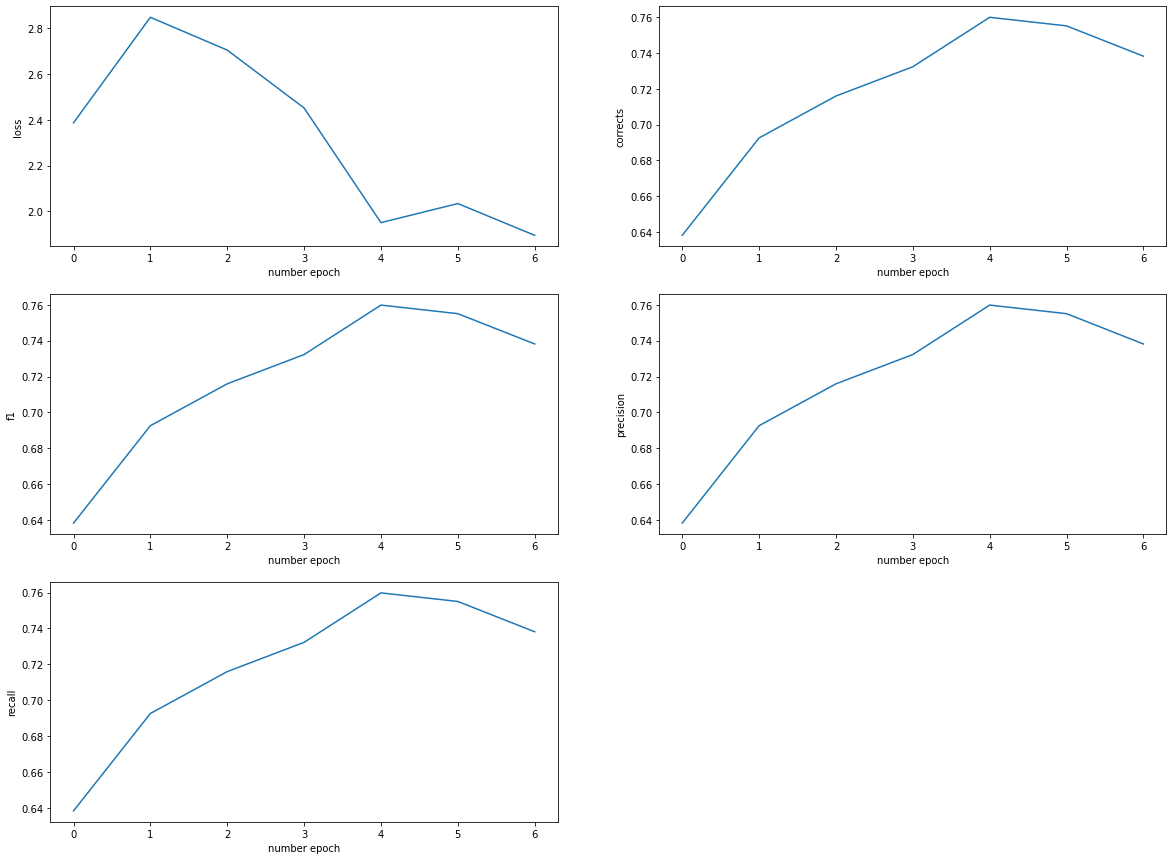

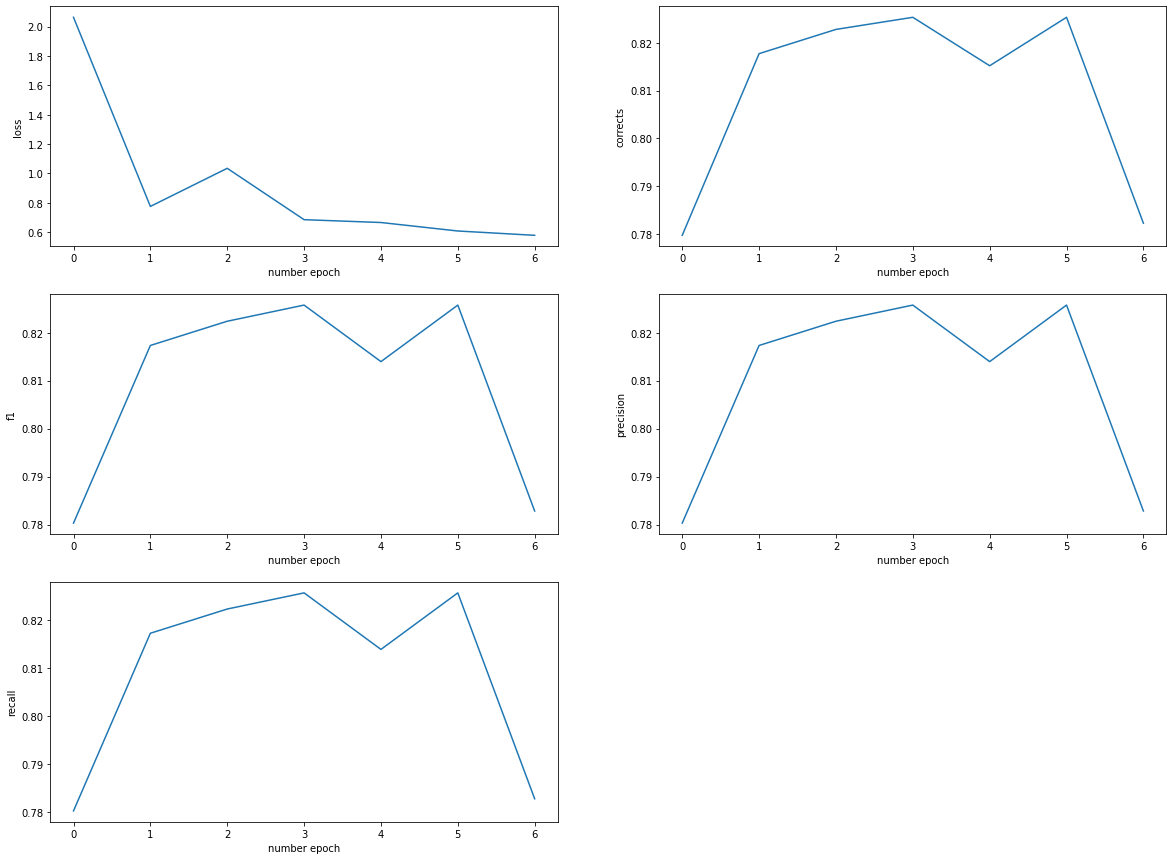

In [0]:
model_extractor = train_model(model_extractor, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=7,  doc_train="doc_train_vgg16_last.txt", doc_valid="doc_valid_vgg16_last.txt")

In [0]:
evaluate_model(model_extractor, criterion, test_loader, gpu_mode=False)

Evaluating model
----------
Test Loss: 0.685126


Test Accuracy (Overall): 82% (326/395)

Evaluation completed in 3m 36s


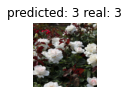

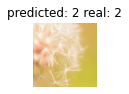

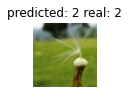

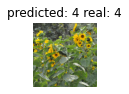

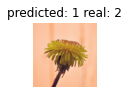

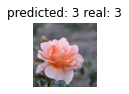

In [0]:
visualize_model(model_extractor)

plt.ioff()
plt.show()

In [0]:
torch.save(model_extractor.state_dict(), 'VGG16.pth')

In [10]:
model_extractor.load_state_dict(torch.load('VGG16_last.pth'))

<All keys matched successfully>

In [13]:
evaluate_model(model_extractor, criterion, test_loader, gpu_mode=False)

Evaluating model
----------
Test Loss: 0.685222


Test Accuracy (Overall): 86% (324/376)

Evaluation completed in 3m 10s
